In [1503]:
import pandas as pd
from itertools import cycle
import numpy as np
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt   
import matplotlib.cm as cm
import warnings
warnings.simplefilter('ignore', category=UserWarning)  # suppresses warning message from Seaborn
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', None) # no limit on visible columns 

# command below ensures matplotlib output can be included in Notebook
%matplotlib inline

# Loading dataset

In [1504]:
df = pd.read_csv("data/Per 100 Poss.csv") # load dataset into a dataframe

df.sample(5) # view sample of data

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg_per_100_poss,fga_per_100_poss,fg_percent,x3p_per_100_poss,x3pa_per_100_poss,x3p_percent,x2p_per_100_poss,x2pa_per_100_poss,x2p_percent,ft_per_100_poss,fta_per_100_poss,ft_percent,orb_per_100_poss,drb_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,pf_per_100_poss,pts_per_100_poss,o_rtg,d_rtg
21734,9233,1983,1757,James Edwards,NaN,C,27,6,NBA,TOT,31,9.0,667,9.3,19.1,0.487,0.0,0.0,NaN,9.3,19.1,0.487,5.0,7.8,0.639,4.1,7.2,11.2,2.9,0.9,1.4,3.6,8.0,23.6,103.0,104.0
10037,21530,2008,2959,Theo Ratliff,NaN,PF,34,13,NBA,MIN,10,6.0,214,5.6,11.0,0.511,0.0,0.2,0.000,5.6,10.7,0.523,4.2,6.1,0.680,3.2,6.3,9.5,1.7,0.7,4.6,2.9,7.3,15.4,105.0,109.0
14532,16393,1999,2860,Eric Piatkowski,NaN,SG,28,5,NBA,LAC,49,38.0,1242,7.8,18.0,0.432,2.8,7.1,0.394,5.0,10.9,0.456,3.8,4.4,0.863,1.7,4.4,6.0,2.3,1.9,0.3,2.3,3.7,22.2,112.0,112.0
22221,8956,1982,1526,Mike Bantom,NaN,SF,30,9,NBA,TOT,82,38.0,2016,8.0,17.0,0.469,0.0,0.1,0.333,7.9,16.9,0.470,4.0,6.4,0.629,4.2,6.4,10.5,2.7,1.5,1.5,3.6,6.5,20.0,99.0,104.0
9095,21765,2009,3248,Eduardo Nájera,NaN,PF,32,9,NBA,NJN,27,0.0,319,5.5,12.4,0.446,0.8,4.2,0.200,4.7,8.2,0.571,1.3,3.7,0.364,2.8,8.4,11.2,3.2,1.7,0.7,3.0,8.4,13.2,93.0,110.0


In [1505]:
df.shape # returns the shape of data - total rows and columns (features)

(25412, 36)

# Pre-processing data

## Removing players from seasons prior to 2013

In [1506]:
df = df.drop(df[df.season < 2013].index)

In [1507]:
df.shape # returns the shape of data - rows and columns (features)

(7150, 36)

## Removing unecessary text from columns

In [1508]:
df.columns # list all the different columns

Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'gs', 'mp', 'fg_per_100_poss',
       'fga_per_100_poss', 'fg_percent', 'x3p_per_100_poss',
       'x3pa_per_100_poss', 'x3p_percent', 'x2p_per_100_poss',
       'x2pa_per_100_poss', 'x2p_percent', 'ft_per_100_poss',
       'fta_per_100_poss', 'ft_percent', 'orb_per_100_poss',
       'drb_per_100_poss', 'trb_per_100_poss', 'ast_per_100_poss',
       'stl_per_100_poss', 'blk_per_100_poss', 'tov_per_100_poss',
       'pf_per_100_poss', 'pts_per_100_poss', 'o_rtg', 'd_rtg'],
      dtype='object')

In [1509]:
for col in df.columns:
  # replacing percent with % sign
  col_modified = col.replace('_percent', '%')
  # remove _per_100_poss from columns that have it
  if "_per_100_poss" in col:
    col_modified = col.split("_")[0]
    
  df = df.rename(columns = {col:col_modified})

df.columns


Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'gs', 'mp', 'fg', 'fga', 'fg%', 'x3p',
       'x3pa', 'x3p%', 'x2p', 'x2pa', 'x2p%', 'ft', 'fta', 'ft%', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'o_rtg', 'd_rtg'],
      dtype='object')

## Preliminary exploration of values in the data

In [1510]:
df.sample(10) # view random rows

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
6085,24602,2014,3805,D.J. Augustin,NaN,PG,26,6,NBA,TOR,10,0.0,82,4.5,15.3,0.292,0.6,7.0,0.091,3.8,8.3,0.462,3.8,3.8,1.000,0.0,2.5,2.5,6.4,0.6,0.0,5.7,4.5,13.4,75.0,111.0
1665,29192,2021,4167,Gorgui Dieng,NaN,C,31,8,NBA,TOT,38,1.0,552,7.4,14.2,0.521,2.6,6.1,0.429,4.8,8.1,0.591,5.0,5.8,0.866,3.5,8.7,12.2,4.2,2.3,1.4,2.8,4.9,22.5,127.0,109.0
1577,29104,2021,4320,Delon Wright,NaN,SG-PG,28,6,NBA,TOT,63,39.0,1748,6.7,14.4,0.463,1.8,4.8,0.372,4.9,9.6,0.509,2.8,3.5,0.802,1.8,5.7,7.5,7.7,2.8,0.8,2.3,2.1,17.9,118.0,113.0
1780,29307,2021,4336,Josh Richardson,NaN,SG,27,6,NBA,DAL,59,56.0,1790,7.3,17.0,0.427,2.4,7.4,0.330,4.8,9.7,0.501,2.7,3.0,0.917,1.4,4.0,5.4,4.2,1.7,0.7,2.2,3.6,19.7,109.0,114.0
4482,26663,2017,3685,Kyle Lowry,NaN,PG,30,11,NBA,TOR,60,60.0,2244,9.6,20.7,0.464,4.4,10.6,0.412,5.3,10.2,0.518,6.8,8.2,0.819,1.1,5.4,6.5,9.4,2.0,0.4,3.9,3.8,30.4,123.0,109.0
3365,28177,2019,4364,Stanley Johnson,NaN,SF,22,4,NBA,DET,48,7.0,961,6.8,17.9,0.381,2.6,9.3,0.282,4.2,8.6,0.488,2.1,2.6,0.804,1.3,7.7,9.0,3.1,2.5,0.7,2.8,4.7,18.4,95.0,107.0
1859,29386,2021,4424,Malcolm Brogdon,NaN,PG,28,5,NBA,IND,56,56.0,1930,10.9,24.0,0.453,3.6,9.2,0.388,7.3,14.8,0.493,3.7,4.3,0.864,1.4,5.8,7.2,8.1,1.2,0.4,2.8,2.7,29.0,113.0,115.0
5796,25575,2015,3698,P.J. Tucker,NaN,SF,29,4,NBA,PHO,78,63.0,2383,5.5,12.5,0.438,1.8,5.3,0.345,3.6,7.2,0.506,2.2,3.0,0.727,2.4,8.1,10.5,2.6,2.2,0.5,2.0,3.7,14.9,108.0,105.0
642,29686,2022,3918,Avery Bradley,NaN,SG,31,12,NBA,LAL,62,45.0,1406,5.0,11.9,0.423,2.8,7.2,0.390,2.3,4.8,0.471,0.5,0.6,0.889,1.1,3.6,4.6,1.6,1.8,0.3,1.3,4.0,13.4,106.0,116.0
4126,27566,2018,4372,Willie Reed,NaN,C,27,3,NBA,TOT,42,5.0,428,9.2,13.8,0.669,0.1,0.2,0.500,9.1,13.5,0.672,3.6,6.3,0.582,4.0,9.8,13.8,1.1,1.0,2.5,2.2,6.4,22.2,125.0,108.0


In [1511]:
df.dtypes # returns the datatype of each column

seas_id         int64
season          int64
player_id       int64
player         object
birth_year    float64
pos            object
age             int64
experience      int64
lg             object
tm             object
g               int64
gs            float64
mp              int64
fg            float64
fga           float64
fg%           float64
x3p           float64
x3pa          float64
x3p%          float64
x2p           float64
x2pa          float64
x2p%          float64
ft            float64
fta           float64
ft%           float64
orb           float64
drb           float64
trb           float64
ast           float64
stl           float64
blk           float64
tov           float64
pf            float64
pts           float64
o_rtg         float64
d_rtg         float64
dtype: object

In [1512]:
df.describe() # view the description of the numerical values in the data set 

,seas_id,season,player_id,birth_year,age,experience,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
count,7150.000000,7150.000000,7150.000000,53.000000,7150.000000,7150.000000,7150.000000,7150.000000,7150.000000,7149.000000,7149.000000,7099.000000,7149.000000,7149.000000,6491.000000,7149.000000,7149.000000,7037.000000,7149.000000,7149.000000,6709.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7116.000000,7149.000000
mean,27484.500000,2018.191608,4186.560559,1986.981132,26.226713,5.459720,42.595245,19.522657,961.848811,7.153854,16.336341,0.439344,1.852399,5.591481,0.304251,5.301637,10.745321,0.490230,3.027263,4.109036,0.737250,2.281522,6.660330,8.941376,4.230648,1.556553,0.984068,2.702756,4.626549,19.186502,105.446318,109.792978
std,2064.171545,3.135926,424.977956,5.238506,4.157743,4.089226,25.501463,25.499963,797.908434,2.972217,5.303745,0.113652,1.641012,4.086564,0.144262,2.998224,5.113191,0.126909,2.339098,2.952030,0.152881,2.320312,3.324658,4.763022,2.950488,1.168565,1.102453,1.650478,2.569354,7.635843,20.088240,5.236136
min,23910.000000,2013.000000,2863.000000,1975.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000
25%,25697.250000,2015.000000,3891.000000,1983.000000,23.000000,2.000000,20.000000,0.000000,233.250000,5.500000,12.900000,0.396000,0.400000,2.400000,0.260000,3.300000,7.300000,0.442000,1.600000,2.300000,0.667000,0.800000,4.500000,5.600000,2.200000,1.000000,0.300000,1.800000,3.300000,14.800000,99.000000,107.000000
50%,27484.500000,2018.000000,4188.500000,1987.000000,26.000000,4.000000,45.000000,6.000000,787.000000,7.000000,15.900000,0.438000,1.800000,5.700000,0.333000,5.000000,10.400000,0.494000,2.700000,3.700000,0.762000,1.500000,6.100000,7.800000,3.400000,1.400000,0.700000,2.500000,4.200000,18.700000,107.000000,110.000000
75%,29271.750000,2021.000000,4490.000000,1990.000000,29.000000,8.000000,66.000000,34.000000,1571.750000,8.800000,19.500000,0.488000,2.900000,8.200000,0.378000,6.900000,13.700000,0.547000,4.000000,5.500000,0.833000,3.300000,8.400000,11.600000,5.700000,1.900000,1.300000,3.400000,5.500000,23.300000,114.000000,113.000000
max,31059.000000,2023.000000,5100.000000,2002.000000,43.000000,22.000000,83.000000,82.000000,3167.000000,52.600000,53.100000,1.000000,50.100000,50.100000,1.000000,52.600000,53.100000,1.000000,49.700000,51.400000,1.000000,52.600000,49.700000,53.100000,49.000000,25.000000,24.100000,38.400000,99.800000,150.400000,300.000000,127.000000


In [1514]:
df.info()  # get info about each feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7150 entries, 0 to 7149
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   seas_id     7150 non-null   int64  
 1   season      7150 non-null   int64  
 2   player_id   7150 non-null   int64  
 3   player      7150 non-null   object 
 4   birth_year  53 non-null     float64
 5   pos         7150 non-null   object 
 6   age         7150 non-null   int64  
 7   experience  7150 non-null   int64  
 8   lg          7150 non-null   object 
 9   tm          7150 non-null   object 
 10  g           7150 non-null   int64  
 11  gs          7150 non-null   float64
 12  mp          7150 non-null   int64  
 13  fg          7149 non-null   float64
 14  fga         7149 non-null   float64
 15  fg%         7099 non-null   float64
 16  x3p         7149 non-null   float64
 17  x3pa        7149 non-null   float64
 18  x3p%        6491 non-null   float64
 19  x2p         7149 non-null  

## Removing unreliable data

In [1516]:
df.isnull().sum() # get the number of missing data points per feature

seas_id          0
season           0
player_id        0
player           0
birth_year    7097
pos              0
age              0
experience       0
lg               0
tm               0
g                0
gs               0
mp               0
fg               1
fga              1
fg%             51
x3p              1
x3pa             1
x3p%           659
x2p              1
x2pa             1
x2p%           113
ft               1
fta              1
ft%            441
orb              1
drb              1
trb              1
ast              1
stl              1
blk              1
tov              1
pf               1
pts              1
o_rtg           34
d_rtg            1
dtype: int64

In [1517]:
# remove players that played less than 30  games out 82 games total possible per season
df = df.drop(df[df.g < 30].index)

# remove players that played less than 1/4 of possible game time
# each game is 48 min long, 1/4 = 12 min
df = df.drop(df[df.mp < (12*82)].index)

# create copy of original dataframe for later use
df_copy = df.copy()

df.isnull().sum() # get the number of missing data points per feature

seas_id          0
season           0
player_id        0
player           0
birth_year    3077
pos              0
age              0
experience       0
lg               0
tm               0
g                0
gs               0
mp               0
fg               0
fga              0
fg%              0
x3p              0
x3pa             0
x3p%           110
x2p              0
x2pa             0
x2p%             0
ft               0
fta              0
ft%              0
orb              0
drb              0
trb              0
ast              0
stl              0
blk              0
tov              0
pf               0
pts              0
o_rtg            0
d_rtg            0
dtype: int64

## Removing irrelevant features

In [1518]:
# drop features that are not player performance stats
df = df.drop(
  ['seas_id', 'birth_year', 'lg','season','player','player_id','experience','tm','age','pos'], axis=1)

# drop features that do not give information about the role of the player on the court
df = df.drop(
  ['g', 'gs', 'mp'], axis=1)

df.columns


Index(['fg', 'fga', 'fg%', 'x3p', 'x3pa', 'x3p%', 'x2p', 'x2pa', 'x2p%', 'ft',
       'fta', 'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'o_rtg', 'd_rtg'],
      dtype='object')

## Checking for uniqueness of data

In [1520]:
# print sum of unique values for each feature
for col in df.columns:
  print(f"{col}: {len(df[col].unique())}")

fg: 126
fga: 235
fg%: 333
x3p: 67
x3pa: 161
x3p%: 297
x2p: 134
x2pa: 245
x2p%: 334
ft: 119
fta: 138
ft%: 440
orb: 82
drb: 143
trb: 195
ast: 147
stl: 39
blk: 56
tov: 65
pf: 77
pts: 334
o_rtg: 62
d_rtg: 30


## Filling Null data

In [1521]:
df.isnull().sum() # get the number of missing data points per column

fg         0
fga        0
fg%        0
x3p        0
x3pa       0
x3p%     110
x2p        0
x2pa       0
x2p%       0
ft         0
fta        0
ft%        0
orb        0
drb        0
trb        0
ast        0
stl        0
blk        0
tov        0
pf         0
pts        0
o_rtg      0
d_rtg      0
dtype: int64

### Filling NaN x3p percent

In [1522]:
# replacing NaN values for 3 point shots % with 0
df['x3p%'] = df['x3p%'].fillna(0)

df.isnull().sum() # check that no Null values are lef

fg       0
fga      0
fg%      0
x3p      0
x3pa     0
x3p%     0
x2p      0
x2pa     0
x2p%     0
ft       0
fta      0
ft%      0
orb      0
drb      0
trb      0
ast      0
stl      0
blk      0
tov      0
pf       0
pts      0
o_rtg    0
d_rtg    0
dtype: int64

In [1523]:
df.sample(10) # view sample of data with the final features

,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
3646,11.3,25.9,0.437,3.6,10.5,0.340,7.8,15.4,0.502,4.5,5.6,0.805,1.0,4.6,5.6,5.5,2.2,0.5,4.1,4.0,30.7,103.0,105.0
203,6.7,14.2,0.471,2.4,6.5,0.374,4.2,7.6,0.554,6.0,7.2,0.832,1.4,5.3,6.7,2.3,1.1,0.2,1.7,1.9,21.8,124.0,118.0
3459,6.5,16.2,0.400,3.5,9.4,0.372,3.0,6.9,0.437,3.1,3.8,0.810,0.7,3.2,4.0,3.7,1.3,0.4,2.1,3.7,19.5,107.0,113.0
2913,6.9,16.0,0.434,1.4,4.8,0.298,5.5,11.2,0.492,3.4,4.3,0.793,2.0,5.7,7.6,7.1,2.5,0.9,2.2,3.0,18.7,112.0,107.0
4443,9.1,20.0,0.454,2.2,6.3,0.356,6.8,13.7,0.498,2.7,3.8,0.708,1.0,4.9,5.9,10.9,2.2,1.0,4.3,3.0,23.0,104.0,108.0
3455,4.5,10.9,0.412,1.2,3.1,0.367,3.3,7.7,0.431,3.3,4.1,0.816,1.5,5.8,7.3,2.9,1.1,0.9,1.7,4.9,13.5,107.0,110.0
6680,4.1,11.2,0.369,0.6,2.5,0.224,3.6,8.7,0.410,4.4,5.7,0.770,1.2,3.9,5.1,2.4,1.1,0.3,1.9,6.0,13.2,97.0,110.0
1116,7.3,16.3,0.449,4.9,10.8,0.449,2.5,5.5,0.449,1.8,2.0,0.896,0.5,5.3,5.8,3.7,1.1,0.2,1.5,2.6,21.3,119.0,113.0
5206,11.2,25.9,0.434,2.5,7.0,0.353,8.8,18.9,0.464,6.1,7.0,0.864,1.2,4.1,5.3,10.2,1.2,0.2,4.6,3.9,31.0,109.0,108.0
4736,6.2,11.6,0.534,0.0,0.1,0.000,6.2,11.6,0.538,3.7,4.8,0.778,5.3,10.2,15.6,5.0,2.2,1.3,3.3,6.3,16.2,118.0,101.0


## Scaling data between 0 and 1

Scaling performed to avoid any one feature having more impact because it has a broader scale of values

In [1524]:
# make copy of dataframe
X = df.copy()
column_names = X.columns

# apply MinMaxScaling
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=column_names)

# show description of newly scaled data
X.describe()

,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
count,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000
mean,0.413918,0.427898,0.343212,0.285336,0.332767,0.314129,0.373270,0.385169,0.436837,0.232994,0.225552,0.665312,0.215152,0.318016,0.298202,0.289634,0.325848,0.150391,0.325753,0.346453,0.368883,0.417203,0.495637
std,0.160828,0.164134,0.136505,0.190825,0.206536,0.121910,0.172266,0.174685,0.135279,0.143795,0.135665,0.137387,0.186339,0.178509,0.186292,0.185478,0.146134,0.132453,0.142553,0.129601,0.152590,0.121226,0.157349
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.297872,0.305263,0.253275,0.135135,0.181818,0.304000,0.243243,0.258303,0.342048,0.130357,0.125683,0.594828,0.079545,0.181818,0.153846,0.147436,0.230769,0.061538,0.219178,0.252747,0.257212,0.342857,0.379310
50%,0.397163,0.417544,0.315502,0.297297,0.352273,0.348000,0.358108,0.372694,0.422658,0.200000,0.202186,0.688218,0.136364,0.272727,0.239819,0.230769,0.307692,0.107692,0.301370,0.329670,0.350962,0.414286,0.517241
75%,0.517730,0.540351,0.399563,0.418919,0.477273,0.380000,0.486486,0.498155,0.511983,0.305357,0.295082,0.764368,0.303977,0.428571,0.411765,0.397436,0.410256,0.184615,0.410959,0.417582,0.461538,0.485714,0.620690
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1431]:
X.sample(5) # view sample of scaled data

,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
565,0.702128,0.757895,0.318777,0.756757,0.812500,0.391,0.418919,0.420664,0.461874,0.628571,0.508197,0.896552,0.056818,0.207792,0.158371,0.641026,0.256410,0.046154,0.506849,0.131868,0.783654,0.628571,0.793103
2304,0.631206,0.557895,0.480349,0.000000,0.005682,0.167,0.722973,0.730627,0.479303,0.350000,0.393443,0.524425,0.500000,0.500000,0.533937,0.147436,0.282051,0.446154,0.328767,0.439560,0.504808,0.457143,0.241379
2248,0.248227,0.301754,0.229258,0.513514,0.590909,0.366,0.101351,0.084871,0.494553,0.114286,0.109290,0.688218,0.181818,0.305195,0.280543,0.115385,0.153846,0.092308,0.191781,0.439560,0.257212,0.442857,0.482759
1008,0.418440,0.424561,0.351528,0.108108,0.159091,0.287,0.466216,0.494465,0.420479,0.250000,0.218579,0.754310,0.261364,0.331169,0.325792,0.160256,0.230769,0.046154,0.178082,0.274725,0.346154,0.414286,0.758621
536,0.553191,0.554386,0.366812,0.743243,0.715909,0.438,0.277027,0.269373,0.468410,0.085714,0.065574,0.869253,0.068182,0.220779,0.167421,0.333333,0.384615,0.076923,0.219178,0.307692,0.492788,0.585714,0.655172


## Reducing dimensions with PCA

Dimensions reduced to improve performance and reduce noise

### Choosing number of components

Text(0, 0.5, 'cumulative explained variance')

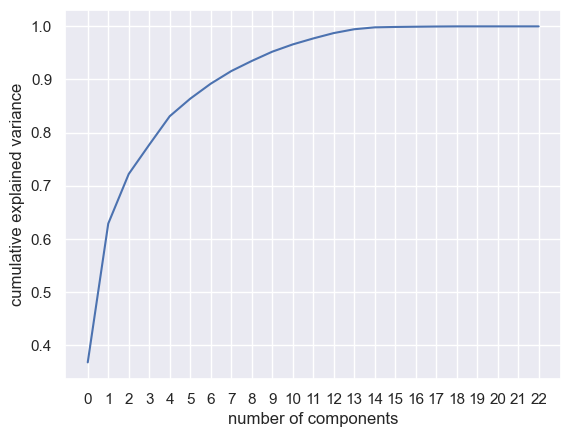

In [1525]:
sns.set()

# Apply PCA to dataset
pca = PCA().fit(X)
number_components = range(len(pca.explained_variance_ratio_))

# Plot the total variance for every different number of principle components combinations
plt.plot(number_components, np.cumsum(pca.explained_variance_ratio_)) 
plt.xticks(number_components)  
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### Reducing to 13 dimensions

In [1433]:
# reduce to 13 dimensions make clustering more effective while maintaining over 99% of data variability
X_PCA = PCA(13).fit_transform(X)

# Machine learning models

## Kmeans

In [1434]:
def kmeans(X, n_clusters):
    """
        Use KMeans to group the data into a specified number of clusters
        
        :param DataFrame X: scaled data to be clustered
        :param int n_clusters: number of clusters required
    """
    
    # Instantiate the model with a particular number of clusters and other parameters
    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=200,
                   n_init=10, random_state=0)

    # fit the model ... i.e. find the n clusters
    model.fit(X)
    
    # Return key cluster information: score, centres and labels
    
    return (model.inertia_, model.cluster_centers_, model.labels_)

## GMM

In [1435]:
def gmm(X, n_clusters):
    """
        Use GMM to group the data into a specified number of clusters
        
        :param DataFrame X: scaled data to be clustered
        :param int n_clusters: number of clusters required
    """
    
    # Model the data with the specified number of multivariate Gaussians

    model = GaussianMixture(n_components=n_clusters, random_state=123,
                            n_init=10)
    
    # fit the model ... i.e. find n Gaussians that fit the data the best

    model.fit(X)

    # Use BIC score to evaluate fit ... could use aic() instead
    # or model.score(X) which gives score of each data row individually

    score = model.bic(X)
    
    # need to call predict(X) to determine which cluster that each point
    # is most likely to belong to

    labels = model.predict(X)

    return (score, model.means_, labels)
    

# Selecting optimal number of clusters 

In [1526]:
# arrays storing 
kbest_scores = []
gmm_scores = []
kmeans_silhouette_scores = []
gmm_silhouette_scores = []

for i in range(2, 11):
      # run kmeans with i clusters
      score, _, labels = kmeans(X_PCA, i)
      sizes = pd.Series(labels).value_counts().to_dict()

      # kmeans inertia score
      print('KMeans has {} clusters with sizes {} with score {:.2f}'
            .format(i, sizes, score))
      kbest_scores.append(score)

      # kmeans silhouette score
      kmeans_silhouette_avg = silhouette_score(X_PCA, labels)
      print("For n_clusters = {}, kmeans silhouette score is {})\n".format(i, kmeans_silhouette_avg))
      kmeans_silhouette_scores.append(kmeans_silhouette_avg)

      # run gmm with i clusters
      score, _, labels = gmm(X_PCA, i)
      sizes = pd.Series(labels).value_counts().to_dict()
      
      # gmm BIC score
      print('GMM has {} clusters with sizes {} with score {:.2f}'
            .format(i, sizes, score))
      gmm_scores.append(score)
      
      # gmm silhouette score
      gmm_silhouette_avg = silhouette_score(X_PCA, labels)
      print("For n_clusters = {}, gmm silhouette score is {})\n".format(i, gmm_silhouette_avg))
      gmm_silhouette_scores.append(gmm_silhouette_avg)

KMeans has 2 clusters with sizes {0: 2289, 1: 801} with score 1272.69
For n_clusters = 2, kmeans silhouette score is 0.30922474320268617)

GMM has 2 clusters with sizes {0: 2178, 1: 912} with score -46774.92
For n_clusters = 2, gmm silhouette score is 0.27166624737107375)

KMeans has 3 clusters with sizes {1: 1511, 0: 868, 2: 711} with score 1029.09
For n_clusters = 3, kmeans silhouette score is 0.23720193830359215)

GMM has 3 clusters with sizes {1: 1437, 2: 858, 0: 795} with score -47427.74
For n_clusters = 3, gmm silhouette score is 0.18961562586949904)

KMeans has 4 clusters with sizes {0: 938, 3: 808, 2: 673, 1: 671} with score 949.81
For n_clusters = 4, kmeans silhouette score is 0.15702569243818762)

GMM has 4 clusters with sizes {2: 1192, 0: 1010, 1: 599, 3: 289} with score -50620.47
For n_clusters = 4, gmm silhouette score is 0.0977220471897501)

KMeans has 5 clusters with sizes {2: 937, 4: 770, 1: 622, 3: 392, 0: 369} with score 882.80
For n_clusters = 5, kmeans silhouette sc

## Plotting GMM and Kmeans scores

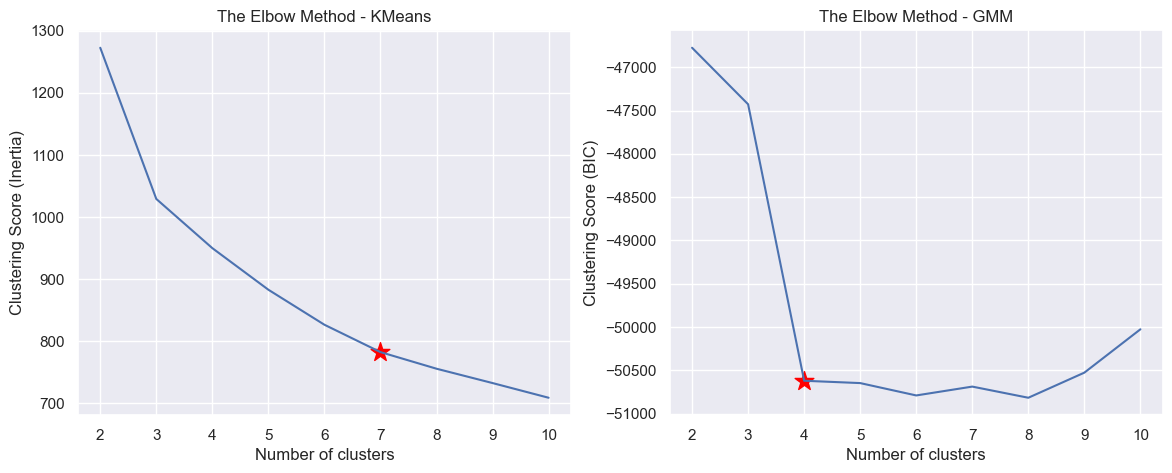

In [1437]:
figure, axis = plt.subplots(1, 2, figsize=(14, 5))
axis[0].plot(range(2, 11), kbest_scores)
axis[0].set_title('The Elbow Method - KMeans')
axis[0].set_xlabel('Number of clusters')
axis[0].set_ylabel('Clustering Score (Inertia)')
axis[0].scatter(7, kbest_scores[5], s = 200, c = 'red', marker='*')
axis[1].plot(range(2, 11), gmm_scores)
axis[1].scatter(4, gmm_scores[2], s = 200, c = 'red', marker='*')
axis[1].set_title('The Elbow Method - GMM')
axis[1].set_xlabel('Number of clusters')
axis[1].set_ylabel('Clustering Score (BIC)')

plt.show() 

## Plotting Kmeans and GMM silhouette scores

Text(0, 0.5, 'Silhouette score')

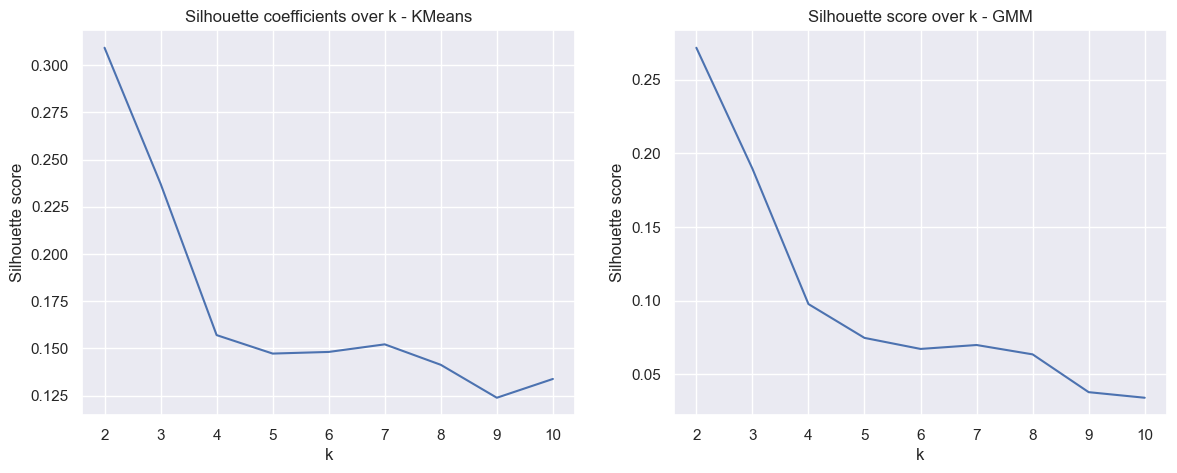

In [1438]:
figure, axis = plt.subplots(1, 2, figsize=(14, 5))
axis[0].plot(range(2, 11), kmeans_silhouette_scores)
axis[0].set_title('Silhouette coefficients over k - KMeans')
axis[0].set_xlabel('k')
axis[0].set_ylabel('Silhouette score')

axis[1].plot(range(2, 11), gmm_silhouette_scores)
axis[1].set_title('Silhouette score over k - GMM')
axis[1].set_xlabel('k')
axis[1].set_ylabel('Silhouette score')

# Plotting models with optimal cluster number 

In [1527]:
# Reducing to 2 dimensions for 2D visualisation
X_2D_PCA = PCA(2).fit_transform(X)

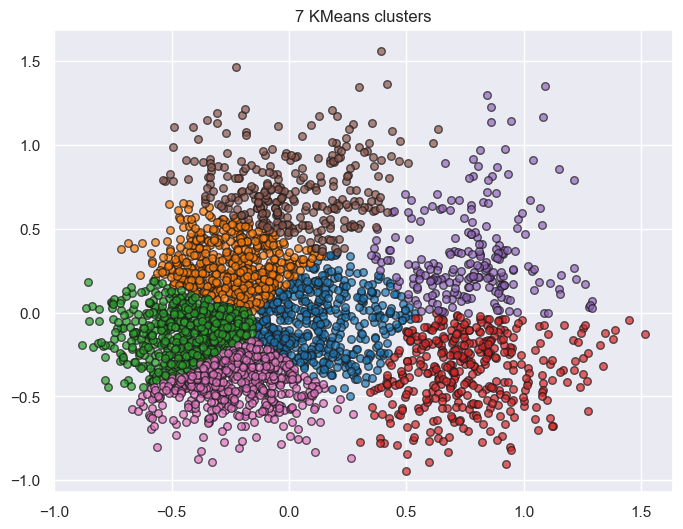

In [1530]:
_, centers, kmeans_labels = kmeans(X_2D_PCA, 7) # run kmeans on reduced dimension data set with 7 clusters

labels = np.unique(kmeans_labels) # get all different labels
colors = cycle(cm.tab10.colors) # get array of colors for different clusters
plt.figure(figsize=(8, 6))
plt.title('7 KMeans clusters')

for label in labels:
    # plot one cluster for each iteration
    color = next(colors)
    # find indeces corresponding to cluser i
    idx = kmeans_labels == label
    # plot cluster
    plt.scatter(X_2D_PCA[idx, 0], X_2D_PCA[idx, 1], color=color, s=30, edgecolor='k', alpha=0.7)

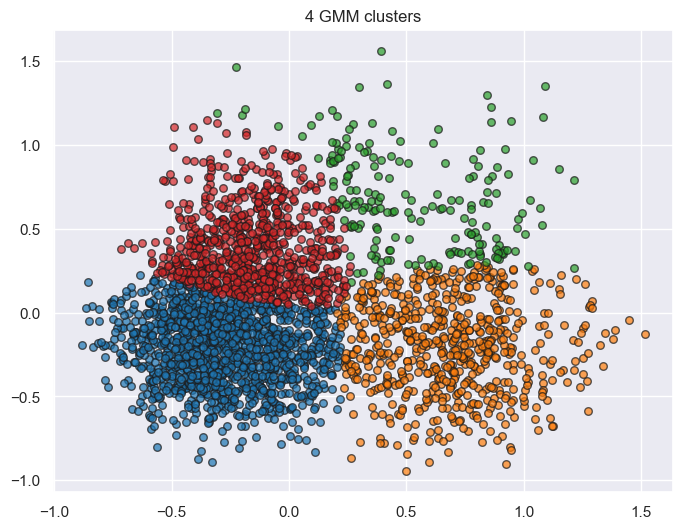

In [1531]:
_, _, gmm_labels = gmm(X_2D_PCA, 4) # run GMM on reduced dimension data set with 4 clusters

labels = np.unique(gmm_labels) # get all different labels
colors = cycle(cm.tab10.colors) # get array of colors for different clusters
plt.figure(figsize=(8, 6))
plt.title('4 GMM clusters')


for label in labels:
    # plot one cluster for each iteration
    color = next(colors)
    # find indeces corresponding to cluser i
    idx = gmm_labels == label
    # plot cluster
    plt.scatter(X_2D_PCA[idx, 0], X_2D_PCA[idx, 1], color=color, s=30, edgecolor='k', alpha=0.7)
    

# Listing clusters

Shows the composition of each cluster using positions from orginal dataset

In [1532]:
def list_clusters(method, X, n_clusters, positions):
    
    score, centres, labels = method(X, n_clusters)
    
    sizes = pd.Series(labels).value_counts().to_dict()

    position_split = {}
    for i, label in enumerate(labels):
        position = positions[i]
        if label not in position_split:
            position_split[label] = {}
        if position not in position_split[label]:
            position_split[label][position] = 0
        position_split[label][position] += 1

    # position_split = dict(sorted(position_split.values()))

    print('\nThere are {} clusters with a total score of {:.1f}\n'
          .format(len(sizes), score))

    # Print positions present in each cluster
    for label, _ in enumerate(centres):
        # sort keys of dictionary for easier visibility
        sorted_positions = dict(sorted(position_split[label].items(),))

        print('Cluster {} has {} players with positions {}\n'
                .format(label, sizes[label], sorted_positions))

    return

### Listing Kmeans clusters

In [1533]:
positions = list(df_copy['pos'])
list_clusters(kmeans, X_PCA, 7, positions)


There are 7 clusters with a total score of 782.3

Cluster 0 has 355 players with positions {'C': 10, 'PF': 33, 'PG': 148, 'PG-SG': 1, 'SF': 69, 'SG': 94}

Cluster 1 has 564 players with positions {'C': 4, 'PF': 56, 'PF-SF': 1, 'PG': 76, 'PG-SG': 1, 'SF': 117, 'SF-PF': 1, 'SF-SG': 6, 'SG': 300, 'SG-PF': 1, 'SG-SF': 1}

Cluster 2 has 463 players with positions {'PF': 8, 'PF-SF': 1, 'PG': 324, 'PG-SG': 2, 'SF': 20, 'SF-SG': 1, 'SG': 100, 'SG-PG': 6, 'SG-SF': 1}

Cluster 3 has 442 players with positions {'C': 74, 'C-PF': 1, 'PF': 220, 'PF-SF': 1, 'PG': 3, 'SF': 102, 'SF-PF': 2, 'SG': 38, 'SG-SF': 1}

Cluster 4 has 251 players with positions {'C': 148, 'PF': 92, 'PF-C': 1, 'PG': 5, 'SF': 3, 'SG': 2}

Cluster 5 has 366 players with positions {'C': 287, 'C-PF': 1, 'PF': 71, 'PG': 1, 'SF': 5, 'SG': 1}

Cluster 6 has 649 players with positions {'C': 15, 'C-PF': 1, 'PF': 127, 'PF-C': 2, 'PF-SF': 3, 'PG': 73, 'SF': 238, 'SF-PF': 1, 'SF-SG': 4, 'SG': 183, 'SG-SF': 2}



### Listing GMM clusters

In [1534]:
list_clusters(gmm, X_PCA, 4, positions)


There are 4 clusters with a total score of -50620.5

Cluster 0 has 1010 players with positions {'C': 39, 'C-PF': 2, 'PF': 308, 'PF-C': 2, 'PF-SF': 4, 'PG': 20, 'SF': 361, 'SF-PF': 2, 'SF-SG': 5, 'SG': 263, 'SG-PF': 1, 'SG-SF': 3}

Cluster 1 has 599 players with positions {'C': 270, 'PF': 207, 'PF-C': 1, 'PG': 51, 'PG-SG': 1, 'SF': 41, 'SF-SG': 1, 'SG': 27}

Cluster 2 has 1192 players with positions {'C': 1, 'PF': 37, 'PF-SF': 2, 'PG': 557, 'PG-SG': 3, 'SF': 149, 'SF-PF': 2, 'SF-SG': 5, 'SG': 428, 'SG-PG': 6, 'SG-SF': 2}

Cluster 3 has 289 players with positions {'C': 228, 'C-PF': 1, 'PF': 55, 'PG': 2, 'SF': 3}



# Merging model cluster predictions into original dataset

In [1537]:
# use copy of original dataset to have access original features
df_cluster = df_copy.copy()

# drop features that are not of interest
df_cluster = df_cluster.drop(
  ['seas_id', 'birth_year','lg','player_id'], axis=1)
# fill null values
df_cluster['x3p%'] = df_cluster['x3p%'].fillna(0)

# Creating labels for each model
_, _, kmeans_labels = kmeans(X_PCA, 7)
_, _, gmm_labels = gmm(X_PCA, 4)


In [1538]:
# merge cluster labels into copy of original dataset
df_cluster['kmeans cluster'] = pd.Series(kmeans_labels, index=df.index)
df_cluster['gmm cluster'] = pd.Series(gmm_labels, index=df.index)

df_cluster.sample(10) # view sample of data

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
1610,2021,Dorian Finney-Smith,PF,27,5,DAL,60,60.0,1921,5.6,12.0,0.472,3.1,7.8,0.394,2.6,4.2,0.616,0.8,1.1,0.756,2.5,5.9,8.4,2.6,1.3,0.6,1.2,3.5,15.1,124.0,114.0,6,0
1576,2021,Dejounte Murray,PG,24,4,SAS,67,67.0,2139,10.0,22.1,0.453,1.4,4.5,0.317,8.6,17.6,0.488,2.4,3.0,0.791,1.3,9.4,10.7,8.2,2.3,0.2,2.7,3.1,23.8,106.0,111.0,2,1
2028,2021,Steven Adams,C,27,8,NOP,58,58.0,1605,5.6,9.2,0.614,0.0,0.1,0.000,5.6,9.1,0.620,1.8,4.0,0.444,6.4,9.0,15.4,3.3,1.6,1.1,2.3,3.4,13.1,122.0,112.0,5,3
2900,2019,Darius Miller,SF,28,5,NOP,69,15.0,1757,5.0,12.8,0.390,3.5,9.6,0.365,1.5,3.2,0.467,1.5,1.9,0.789,0.4,3.0,3.4,3.9,1.1,0.6,1.6,4.4,15.0,110.0,116.0,6,0
115,2023,Darius Garland,PG,23,4,CLE,51,51.0,1794,10.7,23.0,0.468,3.6,8.7,0.419,7.1,14.3,0.497,6.0,6.9,0.862,0.6,3.3,3.9,11.4,1.8,0.1,4.2,3.1,31.1,119.0,112.0,0,2
6066,2014,Chris Douglas-Roberts,SF,27,5,CHA,49,8.0,1016,5.7,12.9,0.440,2.6,6.7,0.386,3.1,6.1,0.500,3.4,4.2,0.805,0.8,5.3,6.1,2.6,1.5,0.8,1.8,3.1,17.3,111.0,105.0,6,0
2982,2019,Fred VanVleet,PG,24,3,TOR,64,28.0,1760,6.7,16.3,0.410,3.0,8.1,0.378,3.6,8.3,0.441,2.6,3.1,0.843,0.6,4.0,4.5,8.4,1.6,0.5,2.2,3.0,19.1,114.0,110.0,1,2
4585,2017,P.J. Tucker,SF,31,6,TOT,81,21.0,2236,4.3,10.5,0.413,1.5,4.3,0.357,2.8,6.2,0.451,1.6,2.0,0.774,2.5,7.7,10.2,2.2,2.5,0.4,1.4,4.3,11.7,109.0,109.0,6,0
4996,2016,Jeremy Lamb,SG,23,4,CHO,66,0.0,1227,9.4,20.9,0.451,2.3,7.4,0.309,7.1,13.5,0.529,2.6,3.6,0.727,1.8,8.5,10.3,3.1,1.7,1.2,2.0,4.3,23.7,104.0,103.0,3,0
1042,2022,Jusuf Nurkić,C,27,8,POR,56,56.0,1579,9.9,18.6,0.535,0.5,1.7,0.268,9.5,16.8,0.563,5.7,8.3,0.690,5.2,14.0,19.2,4.9,1.9,1.1,4.4,5.8,26.1,112.0,112.0,4,1


# View data samples from each kmeans cluster 

In [1539]:
df_cluster[df_cluster["kmeans cluster"] == 0].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
3114,2019,John Wall,PG,28,9,WAS,32,32.0,1104,10.5,23.7,0.444,2.2,7.2,0.302,8.3,16.4,0.507,5.2,7.5,0.697,0.6,4.3,5.0,12.0,2.1,1.2,5.2,3.0,28.4,104.0,114.0,0,2
3646,2018,Donovan Mitchell,SG,21,1,UTA,79,71.0,2638,11.3,25.9,0.437,3.6,10.5,0.340,7.8,15.4,0.502,4.5,5.6,0.805,1.0,4.6,5.6,5.5,2.2,0.5,4.1,4.0,30.7,103.0,105.0,0,2
1114,2022,Luka Dončić,PG,22,4,DAL,65,65.0,2301,14.0,30.7,0.457,4.4,12.4,0.353,9.6,18.2,0.528,8.0,10.7,0.744,1.2,11.7,13.0,12.4,1.6,0.8,6.4,3.2,40.4,110.0,107.0,0,1
1833,2021,Kyrie Irving,PG,28,10,BRK,54,54.0,1886,14.0,27.8,0.506,3.9,9.7,0.402,10.2,18.1,0.561,5.1,5.6,0.922,1.3,5.2,6.6,8.3,1.9,0.9,3.3,3.6,37.1,121.0,114.0,0,2
7033,2013,Ramon Sessions,SG,26,6,CHA,61,0.0,1652,8.8,21.5,0.408,1.0,3.4,0.308,7.7,18.1,0.427,9.2,11.0,0.839,0.9,4.5,5.4,7.3,1.5,0.2,3.3,2.9,27.8,109.0,114.0,0,2


In [1540]:
df_cluster[df_cluster["kmeans cluster"] == 1].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
3040,2019,J.J. Redick,SG,34,13,PHI,76,63.0,2379,9.0,20.4,0.440,4.8,12.0,0.397,4.2,8.4,0.502,4.5,5.1,0.894,0.4,3.3,3.7,4.1,0.6,0.3,2.0,2.6,27.2,118.0,115.0,1,2
674,2022,Bryn Forbes,SG,28,6,TOT,75,2.0,1286,8.7,20.3,0.429,4.6,11.1,0.414,4.1,9.2,0.447,3.0,3.3,0.908,0.4,3.1,3.5,2.8,0.9,0.2,2.1,3.6,25.0,109.0,117.0,1,2
5161,2016,Nikola Mirotić,PF,24,2,CHI,66,38.0,1646,7.6,18.6,0.407,4.1,10.5,0.390,3.4,8.0,0.430,4.4,5.5,0.807,1.8,9.3,11.0,3.0,1.8,1.4,3.1,4.6,23.7,107.0,104.0,1,0
1274,2022,Saddiq Bey,SF,22,2,DET,82,82.0,2704,8.1,20.5,0.396,3.8,11.0,0.346,4.3,9.5,0.454,3.8,4.6,0.827,1.9,6.0,8.0,4.2,1.3,0.3,1.7,2.3,23.8,110.0,116.0,1,0
3909,2018,Marco Belinelli,SG,31,11,ATL,52,1.0,1210,8.0,19.6,0.410,3.7,10.0,0.372,4.3,9.6,0.450,4.1,4.4,0.927,0.6,3.5,4.0,4.2,1.9,0.1,2.2,1.7,23.9,109.0,113.0,1,2


In [1541]:
df_cluster[df_cluster["kmeans cluster"] == 2].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
5618,2015,Jeremy Lin,PG,26,5,LAL,74,30.0,1907,7.4,17.5,0.424,1.7,4.7,0.369,5.7,12.8,0.444,5.7,7.2,0.795,0.7,4.6,5.2,9.1,2.2,0.9,4.4,5.1,22.3,104.0,110.0,2,2
5736,2015,Mario Chalmers,PG,28,7,MIA,80,37.0,2368,6.0,14.8,0.403,1.6,5.5,0.294,4.3,9.3,0.467,4.6,5.9,0.774,0.5,4.1,4.6,6.8,2.7,0.2,3.9,5.6,18.1,100.0,107.0,2,2
4397,2017,Jeff Teague,PG,28,8,IND,82,82.0,2657,7.6,17.1,0.442,1.7,4.7,0.357,5.9,12.4,0.475,6.8,7.8,0.867,0.6,5.6,6.2,12.0,1.9,0.6,4.1,3.1,23.6,115.0,110.0,2,2
6902,2013,Kemba Walker,PG,22,2,CHA,82,82.0,2859,9.7,22.8,0.423,2.0,6.1,0.322,7.7,16.7,0.459,5.4,6.8,0.798,1.1,4.1,5.2,8.6,2.9,0.6,3.7,2.8,26.7,105.0,111.0,2,2
6595,2013,Andre Iguodala,SG,29,9,DEN,80,80.0,2779,7.2,16.0,0.451,1.7,5.2,0.317,5.5,10.8,0.515,2.8,4.9,0.574,1.5,6.2,7.7,7.9,2.5,0.9,3.7,2.3,18.9,105.0,105.0,2,1


In [1545]:
df_cluster[df_cluster["kmeans cluster"] == 3].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
6420,2014,Omri Casspi,PF,25,5,HOU,71,2.0,1283,6.7,15.9,0.422,2.4,6.8,0.347,4.4,9.1,0.479,3.2,4.7,0.680,2.1,8.0,10.1,3.4,1.7,0.5,2.8,3.9,19.0,105.0,106.0,3,0
5505,2015,Ersan İlyasova,PF,27,7,MIL,58,36.0,1319,10.2,21.5,0.472,2.9,7.3,0.389,7.3,14.2,0.515,2.7,4.1,0.645,3.1,7.6,10.7,2.2,1.4,0.7,1.7,5.8,25.9,111.0,103.0,3,0
6528,2014,Thaddeus Young,PF,25,7,PHI,79,78.0,2718,10.4,22.9,0.454,1.6,5.2,0.308,8.8,17.7,0.496,2.9,4.1,0.712,3.0,5.5,8.5,3.2,3.0,0.6,2.9,3.8,25.2,101.0,108.0,3,0
5389,2015,Brandon Bass,PF,29,10,BOS,82,43.0,1929,8.9,17.7,0.504,0.2,0.8,0.281,8.7,16.9,0.515,4.4,5.6,0.790,3.6,6.7,10.3,2.7,1.1,0.8,2.2,3.6,22.5,112.0,106.0,3,1
4691,2017,Tony Allen,SG,35,13,MEM,71,66.0,1914,7.4,16.2,0.461,0.4,1.5,0.278,7.0,14.7,0.479,2.2,3.5,0.615,4.5,6.1,10.6,2.7,3.1,0.8,2.7,4.8,17.5,101.0,105.0,3,0


In [1546]:
df_cluster[df_cluster["kmeans cluster"] == 4].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
645,2022,Bam Adebayo,C,24,5,MIA,56,56.0,1825,11.1,20.0,0.557,0.0,0.2,0.000,11.1,19.8,0.562,7.0,9.3,0.753,3.8,11.7,15.5,5.2,2.2,1.2,4.1,4.7,29.3,117.0,104.0,4,3
6105,2014,David Lee,PF,30,9,GSW,69,67.0,2288,11.2,21.4,0.523,0.0,0.0,0.000,11.2,21.4,0.523,5.0,6.5,0.780,4.0,10.1,14.0,3.2,1.0,0.6,3.3,4.5,27.4,111.0,103.0,4,3
2997,2019,Giannis Antetokounmpo,PF,24,6,MIL,72,72.0,2358,14.2,24.6,0.578,1.0,4.0,0.256,13.2,20.6,0.641,9.9,13.5,0.729,3.1,14.6,17.7,8.4,1.8,2.2,5.3,4.6,39.3,121.0,99.0,4,1
3655,2018,Dwight Howard,C,32,14,CHO,81,81.0,2463,10.0,18.0,0.555,0.0,0.1,0.143,10.0,17.9,0.559,6.6,11.5,0.574,5.0,15.0,20.0,2.1,1.0,2.6,4.1,4.9,26.7,108.0,104.0,4,1
4459,2017,Karl-Anthony Towns,C,21,2,MIN,82,82.0,3030,13.4,24.8,0.542,1.7,4.6,0.367,11.7,20.2,0.582,6.0,7.2,0.832,5.0,11.9,16.9,3.7,0.9,1.7,3.5,4.0,34.5,121.0,110.0,4,1


In [1547]:
df_cluster[df_cluster["kmeans cluster"] == 5].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
1249,2022,Richaun Holmes,C,28,7,SAC,45,37.0,1074,8.9,13.4,0.660,0.1,0.2,0.400,8.8,13.2,0.664,3.1,4.0,0.778,4.2,10.0,14.2,2.2,0.8,1.8,2.5,5.7,21.0,127.0,114.0,5,1
3804,2018,John Henson,C,27,6,MIL,76,69.0,1970,7.3,12.7,0.572,0.0,0.2,0.143,7.2,12.5,0.578,2.3,4.0,0.570,3.8,9.2,13.0,2.9,1.1,2.8,2.1,5.1,16.8,115.0,108.0,5,1
5759,2015,Miles Plumlee,C,26,3,PHO,54,28.0,1005,5.3,9.7,0.549,0.0,0.0,0.000,5.3,9.7,0.549,0.9,1.9,0.500,4.7,8.9,13.6,1.3,1.7,2.7,2.2,4.9,11.6,108.0,103.0,5,3
1573,2021,DeAndre Jordan,C,32,13,BRK,57,43.0,1246,7.4,9.6,0.763,0.0,0.0,0.000,7.4,9.6,0.766,1.8,3.6,0.500,4.5,12.0,16.5,3.6,0.7,2.5,3.3,4.5,16.5,127.0,111.0,5,3
7102,2013,Thomas Robinson,PF,21,1,TOT,70,0.0,1056,6.7,15.5,0.430,0.0,0.0,0.000,6.7,15.4,0.431,2.7,5.3,0.523,5.9,9.3,15.2,2.2,2.0,1.3,4.2,6.0,16.1,90.0,107.0,5,3


In [1548]:
df_cluster[df_cluster["kmeans cluster"] == 6].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
4654,2017,Solomon Hill,SF,25,4,NOP,80,71.0,2374,3.8,9.9,0.383,1.9,5.6,0.348,1.8,4.3,0.428,2.1,2.6,0.805,1.1,5.3,6.3,2.9,1.5,0.7,1.7,3.8,11.6,103.0,109.0,6,0
3739,2018,Jae Crowder,SF,27,6,TOT,80,47.0,2090,6.4,15.9,0.404,2.6,8.1,0.323,3.8,7.8,0.488,2.9,3.5,0.818,1.4,5.1,6.5,2.3,1.5,0.5,1.7,4.4,18.3,105.0,111.0,6,0
5782,2015,Nik Stauskas,SG,21,1,SAC,73,1.0,1127,4.8,13.2,0.365,2.1,6.7,0.322,2.7,6.6,0.408,2.5,2.9,0.859,0.5,3.4,3.9,3.0,0.9,0.8,1.8,4.1,14.2,100.0,113.0,6,0
3823,2018,Josh Hart,SG,22,1,LAL,63,23.0,1461,5.8,12.3,0.469,2.6,6.5,0.396,3.2,5.8,0.551,2.2,3.1,0.702,1.4,7.2,8.6,2.6,1.5,0.5,1.5,3.5,16.2,116.0,109.0,6,0
640,2022,Austin Reaves,SG,23,1,LAL,61,19.0,1418,4.9,10.7,0.459,1.8,5.6,0.317,3.1,5.1,0.616,3.3,4.0,0.839,1.5,5.0,6.5,3.7,1.0,0.7,1.4,2.9,15.0,123.0,116.0,6,0


# Creating dataframes with means of features for each cluster 

### Selecting columns to include in means dataframe

In [1456]:
df_copy.columns

Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'gs', 'mp', 'fg', 'fga', 'fg%', 'x3p',
       'x3pa', 'x3p%', 'x2p', 'x2pa', 'x2p%', 'ft', 'fta', 'ft%', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'o_rtg', 'd_rtg'],
      dtype='object')

In [1457]:
selected_columns = [
  'age', 'experience', 'g',
  'gs', 'mp', 'fg', 'fga', 'fg%', 'x3p', 'x3pa', 'x3p%', 'x2p', 'x2pa',
  'x2p%', 'ft', 'fta', 'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk',
  'tov', 'pf', 'pts', 'o_rtg', 'd_rtg'
]

### Creating new df with means of all features for kmeans clusters

In [1458]:
df_cluster_grouped_kmeans = df_cluster.groupby(['kmeans cluster'])[selected_columns].mean()

df_cluster_grouped_kmeans


,age,experience,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
kmeans cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,26.847887,7.614085,62.377465,56.366197,2101.287324,11.476056,25.050986,0.458161,3.042817,8.329859,0.357645,8.436338,16.718028,0.505304,6.746197,8.125915,0.829048,1.260845,6.303099,7.567324,7.962535,1.737183,0.634930,4.088451,3.193803,32.736901,112.628169,110.394366
1,26.854610,6.310284,64.764184,33.953901,1731.329787,8.208688,19.154610,0.428959,3.731028,9.851064,0.378603,4.476418,9.304078,0.482562,3.043972,3.676418,0.826807,0.939894,4.959574,5.898759,4.016135,1.380674,0.474291,2.268440,3.476418,23.191844,109.969858,112.597518
2,26.639309,6.302376,65.725702,36.622030,1763.352052,7.753780,18.016847,0.430853,1.855940,5.417927,0.332389,5.894816,12.600864,0.468451,3.520086,4.444276,0.785099,1.030022,4.870194,5.899568,8.451404,1.880778,0.459611,3.580778,3.697408,20.875810,105.393089,109.814255
3,25.592760,5.723982,66.579186,41.201357,1748.377828,8.456561,18.124661,0.468208,1.873756,5.389819,0.342726,6.585520,12.737104,0.520783,3.428507,4.542534,0.753986,2.522851,8.055204,10.578733,3.357240,1.480317,1.226923,2.542534,4.264480,22.216063,109.047511,108.404977
4,26.478088,6.852590,67.709163,53.605578,1974.003984,11.105179,21.427888,0.520689,0.502390,1.588446,0.240725,10.603187,19.841036,0.537267,5.366932,7.318725,0.735159,4.204781,10.896813,15.099203,4.244622,1.448207,1.789243,3.511952,4.619522,28.087251,111.665339,105.183267
5,26.133880,6.032787,68.551913,40.849727,1590.636612,7.339891,13.045628,0.565904,0.077869,0.317213,0.093743,7.258197,12.722951,0.574251,3.226776,4.987158,0.648161,5.142350,10.046175,15.189344,2.658470,1.329508,2.223224,2.497814,5.453825,17.984699,117.374317,105.956284
6,27.092450,5.992296,66.164869,32.493066,1585.807396,5.602003,13.059322,0.430422,2.308012,6.438367,0.354467,3.293991,6.620339,0.500066,1.881818,2.485824,0.756641,1.481048,5.765794,7.243606,3.638521,1.669029,0.785516,1.965794,4.123267,15.396918,108.693374,109.906009


### Creating new df with means of all columns for gmm clusters

In [1459]:
df_cluster_grouped_gmm = df_cluster.groupby(['gmm cluster'])[selected_columns].mean()

df_cluster_grouped_gmm


,age,experience,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
gmm cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,26.506931,5.884158,66.749505,34.524752,1661.542574,6.931485,15.737129,0.440604,2.545743,7.024554,0.356172,4.385842,8.712871,0.505336,2.443564,3.199703,0.763134,1.721485,6.403960,8.125050,3.085149,1.571584,0.812079,2.057525,4.078317,18.854356,108.871287,109.667327
1,26.552588,6.786311,65.767947,46.754591,1804.898164,9.382805,18.620200,0.508032,1.121703,3.331720,0.306977,8.259265,15.290985,0.544003,4.442905,5.983472,0.734164,3.434057,9.459098,12.891820,4.812354,1.447913,1.720200,3.164107,4.532888,24.333055,113.290484,107.150250
2,26.695470,6.449664,64.437919,40.473993,1827.824664,8.628523,19.765101,0.434691,2.752852,7.545805,0.358259,5.875587,12.219044,0.478788,4.099581,4.992534,0.816267,0.984983,4.940604,5.924916,6.821477,1.697399,0.448490,3.222483,3.485487,24.105285,108.652685,111.250000
3,26.363322,6.335640,68.975779,43.944637,1662.352941,7.732526,14.082353,0.556048,0.000000,0.041869,0.000000,7.732526,14.032180,0.557917,3.426644,5.302422,0.645976,5.185467,10.314533,15.501384,2.625260,1.300692,2.198616,2.662284,5.307612,18.892042,114.865052,105.214533


# Visualisation of data

Only performed for kmeans as the model created superior results

In [1549]:
# get cluster numbers
clusters = df_cluster_grouped_kmeans.index
# load colors for each cluster
cluster_colors = cm.tab10.colors

# Usage

## Games started

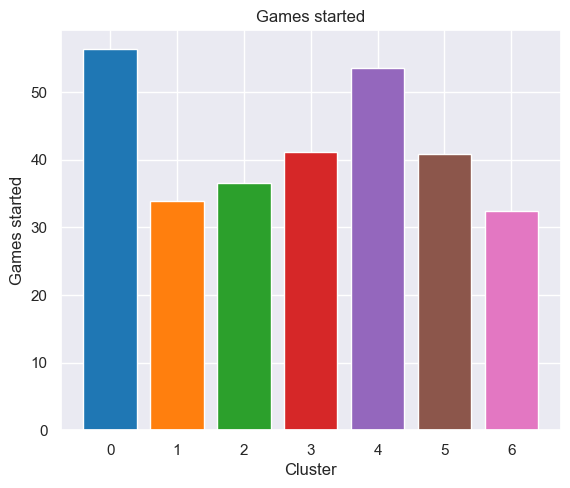

In [1550]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting games started for each cluster
gs = df_cluster_grouped_kmeans['gs']

ax.bar(clusters,gs, color=cluster_colors)
ax.set_title('Games started')
ax.set_xlabel('Cluster')
ax.set_ylabel('Games started')
plt.show()

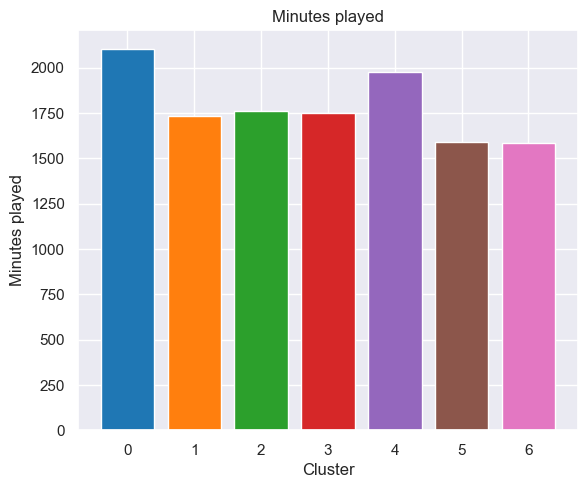

In [1551]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting minutes played for each cluster
mp = df_cluster_grouped_kmeans['mp']

ax.bar(clusters,mp, color=cluster_colors)
ax.set_title('Minutes played')
ax.set_xlabel('Cluster')
ax.set_ylabel('Minutes played')
plt.show()

# Offensive stats

## Points scored

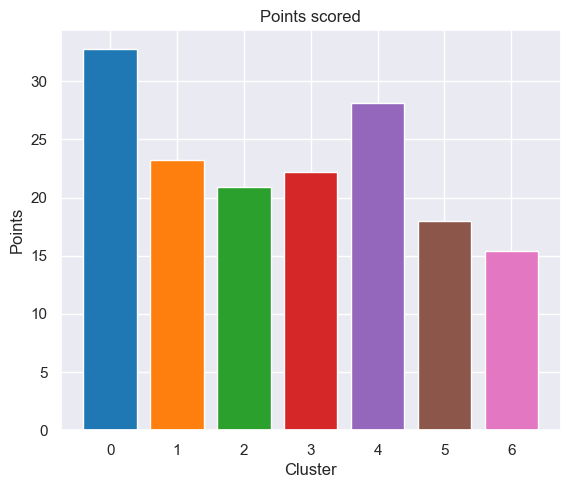

In [1553]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting points for each cluster
points = df_cluster_grouped_kmeans['pts']

ax.bar(clusters,points, color=cluster_colors)
ax.set_title('Points scored')
ax.set_xlabel('Cluster')
ax.set_ylabel('Points')
plt.show()

## Assists

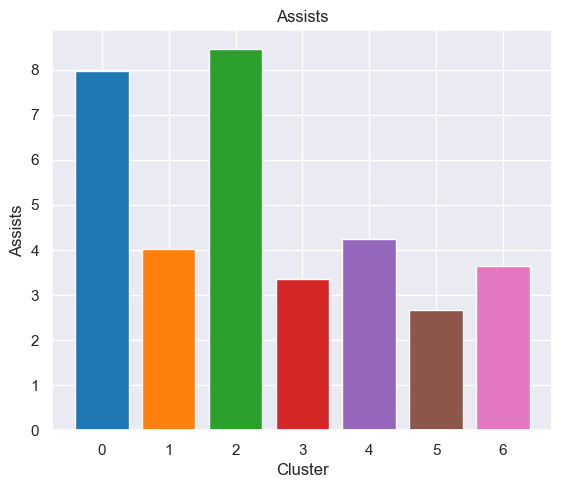

In [1554]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting assists for each cluster
assists = df_cluster_grouped_kmeans['ast']

ax.bar(clusters,assists, color=cluster_colors)
ax.set_title('Assists')
ax.set_xlabel('Cluster')
ax.set_ylabel('Assists')
plt.show()

## Turnovers

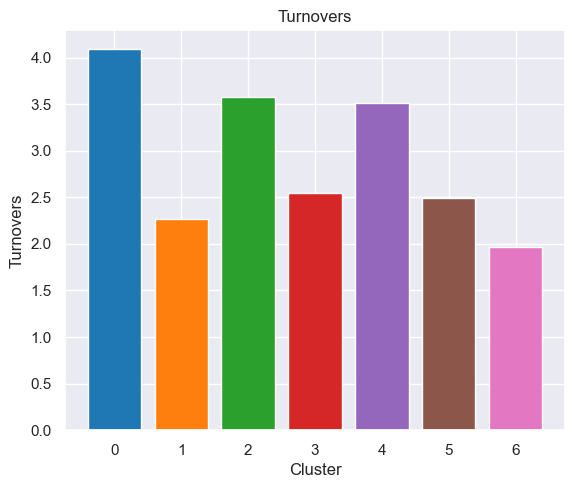

In [1555]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting turnovers for each cluster
turnovers = df_cluster_grouped_kmeans['tov']

ax.bar(clusters,turnovers, color=cluster_colors)
ax.set_title('Turnovers')
ax.set_xlabel('Cluster')
ax.set_ylabel('Turnovers')
plt.show()

# Rebounds

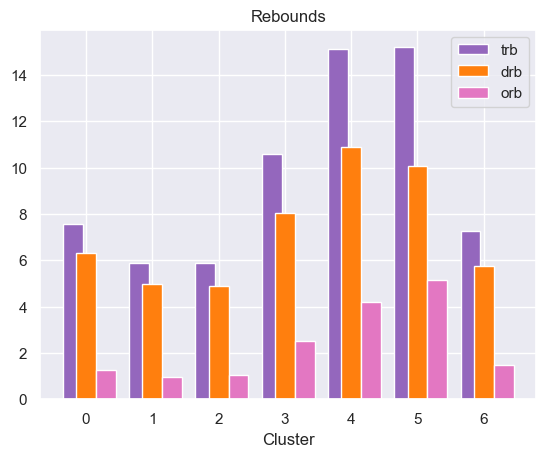

In [1556]:
# get all the different rebound stats for each cluster
total_rebounds = df_cluster_grouped_kmeans['trb']
defensive_rebounds = df_cluster_grouped_kmeans['drb']
offensive_rebounds = df_cluster_grouped_kmeans['orb']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, total_rebounds, width=w, color=cluster_colors[4], align='center')
ax.bar(x, defensive_rebounds, width=w, color=cluster_colors[1], align='center')
ax.bar(x+w, offensive_rebounds, width=w, color=cluster_colors[6], align='center')
ax.legend(('trb', 'drb','orb') )
ax.set_xlabel('Cluster')
ax.set_title('Rebounds')

plt.show()


# Shooting

## Shooting attempts

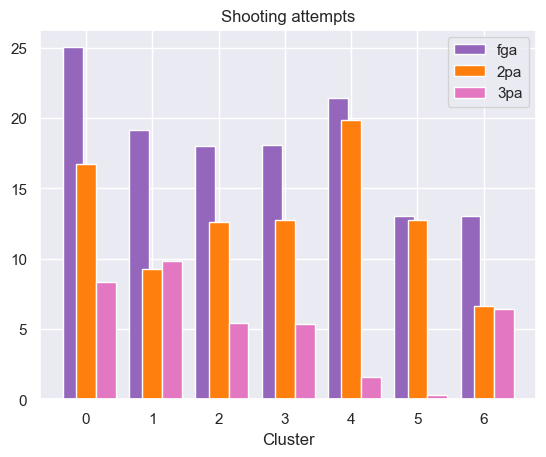

In [1557]:
# getting shooting attemps for each cluster
fg_percent = df_cluster_grouped_kmeans['fga']
two_point_attempts = df_cluster_grouped_kmeans['x2pa']
three_point_attempts = df_cluster_grouped_kmeans['x3pa']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, fg_percent, width=w, color=cluster_colors[4], align='center')
ax.bar(x, two_point_attempts, width=w, color=cluster_colors[1], align='center')
ax.bar(x+w, three_point_attempts, width=w, color=cluster_colors[6], align='center')
ax.legend(('fga', '2pa','3pa') )
ax.set_xlabel('Cluster')
ax.set_title('Shooting attempts')

plt.show()


## Shooting accuracy

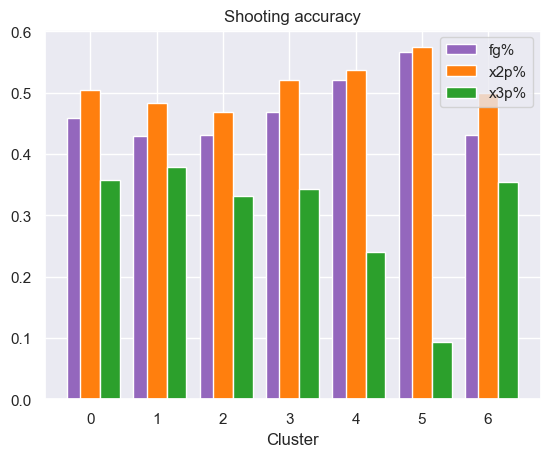

In [1558]:
# getting shooting accuracy columns for each cluster
fg_percent = df_cluster_grouped_kmeans['fg%']
x2p_percent = df_cluster_grouped_kmeans['x2p%']
x3p_percent = df_cluster_grouped_kmeans['x3p%']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, fg_percent, width=w, color=cluster_colors[4], align='center')
ax.bar(x, x2p_percent, width=w, color=cluster_colors[1], align='center')
ax.bar(x+w, x3p_percent, width=w, color=cluster_colors[2], align='center')
ax.legend(('fg%', 'x2p%','x3p%') )
ax.set_xlabel('Cluster')
ax.set_title('Shooting accuracy')

plt.show()


# Free throws

## Free throw attempts

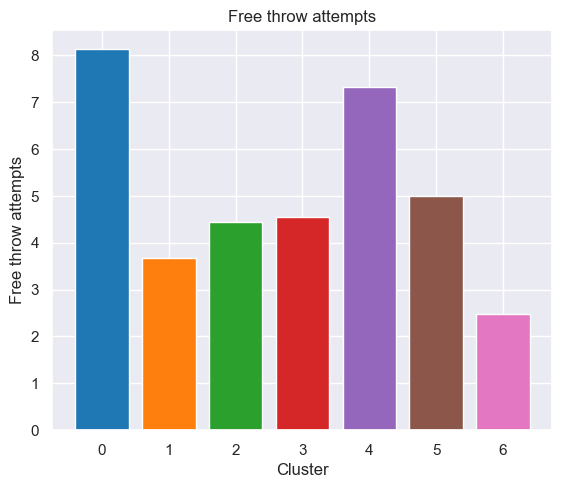

In [1559]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting free throw attempts for each cluster
turnovers = df_cluster_grouped_kmeans['fta']

ax.bar(clusters,turnovers, color=cluster_colors)
ax.set_title('Free throw attempts')
ax.set_xlabel('Cluster')
ax.set_ylabel('Free throw attempts')
plt.show()

## Free throw accuracy

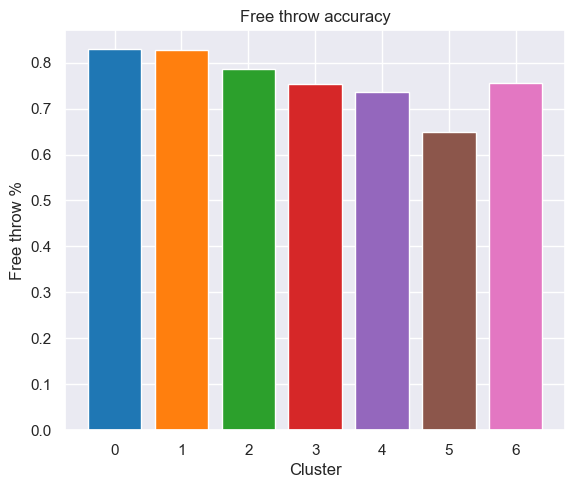

In [1560]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting free throw % for each cluster
turnovers = df_cluster_grouped_kmeans['ft%']

ax.bar(clusters,turnovers, color=cluster_colors)
ax.set_title('Free throw accuracy')
ax.set_xlabel('Cluster')
ax.set_ylabel('Free throw %')
plt.show()

# Defensive contributions

## Blocks and steals

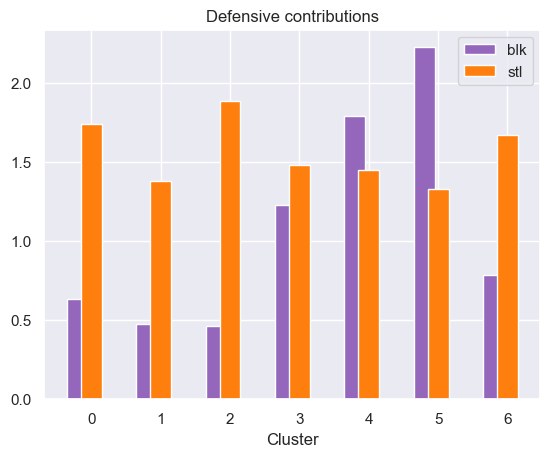

In [1561]:
# getting blocks and steals for each cluster
blocks = df_cluster_grouped_kmeans['blk']
steals = df_cluster_grouped_kmeans['stl']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, blocks, width=w, color=cluster_colors[4], align='center')
ax.bar(x, steals, width=w, color=cluster_colors[1], align='center')
ax.legend(('blk','stl','pf') )
ax.set_xlabel('Cluster')
ax.set_title('Defensive contributions')

plt.show()


## Personal fouls

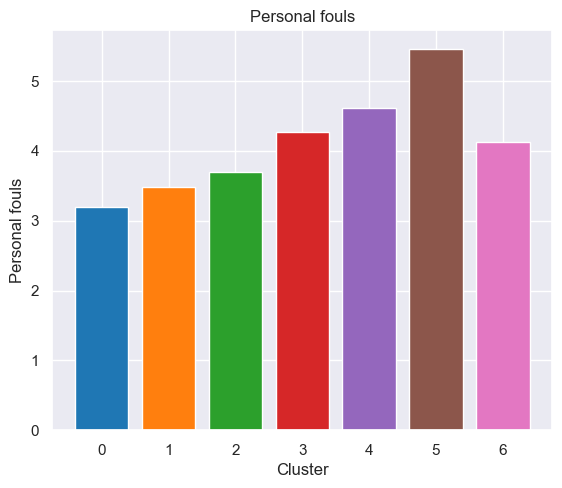

In [1565]:
# getting personal fouls for each cluster
personal_fouls = df_cluster_grouped_kmeans['pf']

fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

ax.bar(clusters,personal_fouls, color=cluster_colors)
ax.set_title('Personal fouls')
ax.set_xlabel('Cluster')
ax.set_ylabel('Personal fouls')
plt.show()

# Defensive and Offensive ratings

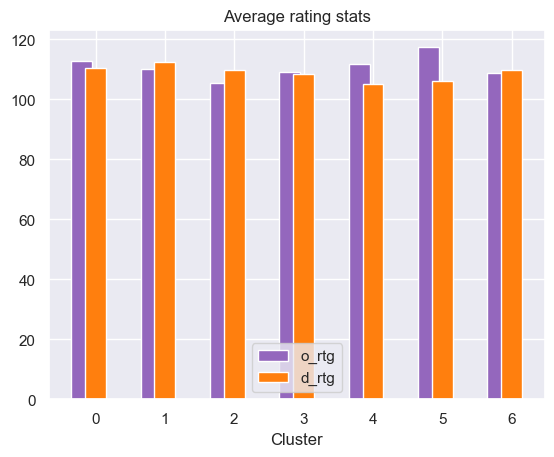

In [1566]:
# getting offensive and defensive ratings for each cluset
o_rtg = df_cluster_grouped_kmeans['o_rtg']
d_rtg = df_cluster_grouped_kmeans['d_rtg']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, o_rtg, width=w, color=cluster_colors[4], align='center')
ax.bar(x, d_rtg, width=w, color=cluster_colors[1], align='center')
ax.legend(('o_rtg', 'd_rtg') )
ax.set_xlabel('Cluster')
ax.set_title('Average rating stats')

plt.show()


# Individual Player analysis

In [1474]:
df_cluster[df_cluster.player == "LeBron James"]

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
375,2023,LeBron James,PF,38,20,LAL,45,45.0,1632,14.9,29.4,0.508,2.8,9.0,0.310,12.1,20.4,0.596,6.3,8.3,0.762,1.5,9.5,11.0,9.1,1.2,0.7,4.1,2.1,39.0,116.0,114.0,0,2
1106,2022,LeBron James,PF,37,19,LAL,56,56.0,2084,14.7,28.1,0.524,3.7,10.3,0.359,11.0,17.8,0.620,5.8,7.7,0.756,1.4,9.1,10.6,8.0,1.7,1.4,4.5,2.8,39.0,117.0,111.0,0,1
1844,2021,LeBron James,PG,36,18,LAL,45,45.0,1504,13.7,26.6,0.513,3.4,9.2,0.365,10.3,17.4,0.591,5.8,8.2,0.698,0.9,10.3,11.2,11.3,1.6,0.8,5.4,2.3,36.4,114.0,106.0,0,1
2526,2020,LeBron James,PG,35,17,LAL,67,67.0,2316,13.2,26.8,0.493,3.0,8.7,0.348,10.2,18.0,0.564,5.4,7.8,0.693,1.4,9.4,10.8,14.0,1.6,0.7,5.4,2.4,34.9,116.0,106.0,0,2
3197,2019,LeBron James,SF,34,16,LAL,55,55.0,1937,13.4,26.3,0.510,2.7,7.9,0.339,10.7,18.4,0.582,6.7,10.0,0.665,1.4,9.8,11.2,10.9,1.7,0.8,4.7,2.3,36.2,114.0,108.0,0,1
3882,2018,LeBron James,PF,33,15,CLE,82,82.0,3026,13.9,25.6,0.542,2.4,6.6,0.367,11.5,19.0,0.603,6.3,8.6,0.731,1.6,9.9,11.5,12.1,1.9,1.1,5.6,2.2,36.4,118.0,109.0,0,1
4501,2017,LeBron James,SF,32,14,CLE,74,74.0,2794,13.1,24.0,0.548,2.2,6.1,0.363,10.9,17.9,0.611,6.4,9.5,0.674,1.7,9.7,11.4,11.5,1.6,0.8,5.4,2.4,34.9,119.0,108.0,0,1
5099,2016,LeBron James,SF,31,13,CLE,76,76.0,2709,14.0,26.9,0.520,1.7,5.4,0.309,12.3,21.5,0.573,6.8,9.3,0.731,2.1,8.6,10.7,9.8,2.0,0.9,4.7,2.7,36.5,116.0,103.0,0,1
5712,2015,LeBron James,SF,30,12,CLE,69,69.0,2493,13.0,26.7,0.488,2.5,7.1,0.354,10.5,19.6,0.536,7.8,11.0,0.710,1.1,7.6,8.7,10.7,2.3,1.0,5.7,2.8,36.3,112.0,105.0,0,2
6336,2014,LeBron James,PF,29,11,MIA,77,77.0,2902,13.9,24.5,0.567,2.1,5.5,0.379,11.8,19.0,0.622,8.0,10.6,0.750,1.5,8.2,9.7,8.8,2.2,0.5,4.9,2.3,37.9,121.0,105.0,0,1


In [1475]:
df_cluster[df_cluster.player == "Ben Simmons"]


,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
32,2023,Ben Simmons,PG,26,5,BRK,42,33.0,1105,5.9,10.4,0.566,0.0,0.1,0.000,5.9,10.3,0.571,1.1,2.5,0.439,1.8,9.9,11.6,11.3,2.4,1.1,4.3,6.1,12.9,111.0,110.0,5,1
1464,2021,Ben Simmons,PG,24,4,PHI,58,58.0,1877,8.4,15.0,0.557,0.1,0.3,0.300,8.3,14.7,0.562,4.5,7.4,0.613,2.4,8.3,10.7,10.3,2.4,0.9,4.4,4.4,21.3,114.0,106.0,4,1
2165,2020,Ben Simmons,PG,23,3,PHI,57,57.0,2017,9.0,15.5,0.580,0.0,0.2,0.286,9.0,15.4,0.583,4.4,7.2,0.621,2.7,8.0,10.7,10.9,2.9,0.8,4.8,4.5,22.5,116.0,106.0,4,1
2817,2019,Ben Simmons,PG,22,2,PHI,79,79.0,2700,9.4,16.8,0.563,0.0,0.1,0.000,9.4,16.7,0.566,4.5,7.5,0.600,3.0,9.2,12.2,10.7,2.0,1.1,4.8,3.7,23.4,114.0,108.0,4,1
3522,2018,Ben Simmons,PG,21,1,PHI,81,81.0,2732,9.6,17.6,0.545,0.0,0.2,0.000,9.6,17.4,0.551,3.4,6.0,0.560,2.6,9.0,11.6,11.6,2.5,1.2,4.9,3.7,22.5,111.0,102.0,4,1


In [1476]:
df_cluster[df_cluster.player == "Nikola Jokić"]


,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
453,2023,Nikola Jokić,C,27,8,DEN,51,51.0,1714,13.6,21.5,0.632,1.2,3.1,0.391,12.4,18.4,0.673,7.3,8.9,0.822,3.0,13.6,16.6,14.6,1.8,1.0,5.1,3.8,35.8,135.0,109.0,4,1
1203,2022,Nikola Jokić,C,26,7,DEN,74,74.0,2476,15.1,26.0,0.583,1.9,5.7,0.337,13.2,20.3,0.652,7.5,9.3,0.810,4.1,16.1,20.2,11.6,2.2,1.2,5.6,3.8,39.7,126.0,105.0,4,1
1929,2021,Nikola Jokić,C,25,6,DEN,72,72.0,2488,14.5,25.7,0.566,1.8,4.7,0.388,12.7,21.0,0.606,6.8,7.8,0.868,4.1,11.4,15.5,11.9,1.9,1.0,4.4,3.8,37.7,130.0,109.0,4,1
2606,2020,Nikola Jokić,C,24,5,DEN,73,73.0,2336,12.0,22.7,0.528,1.7,5.4,0.314,10.3,17.3,0.594,5.2,6.4,0.817,3.5,11.5,15.0,10.8,1.8,0.9,4.8,4.7,30.8,119.0,108.0,4,1
3273,2019,Nikola Jokić,C,23,4,DEN,80,80.0,2504,12.1,23.7,0.511,1.6,5.3,0.307,10.5,18.4,0.569,5.7,6.9,0.821,4.5,12.5,17.0,11.4,2.1,1.1,4.9,4.5,31.5,119.0,105.0,4,1
3967,2018,Nikola Jokić,C,22,3,DEN,75,73.0,2443,10.2,20.5,0.499,2.3,5.7,0.396,8.0,14.8,0.538,5.4,6.4,0.850,4.0,12.3,16.3,9.3,1.8,1.2,4.3,4.3,28.1,121.0,107.0,4,1
4572,2017,Nikola Jokić,C,21,2,DEN,73,59.0,2038,11.8,20.5,0.578,1.1,3.3,0.324,10.8,17.1,0.628,4.5,5.5,0.825,5.1,12.1,17.2,8.6,1.5,1.3,4.1,5.1,29.3,126.0,109.0,4,1
5160,2016,Nikola Jokić,C,20,1,DEN,80,55.0,1733,8.9,17.4,0.512,0.8,2.4,0.333,8.1,14.9,0.541,4.5,5.5,0.811,5.2,11.0,16.2,5.5,2.3,1.4,3.0,6.0,23.0,118.0,104.0,4,1


In [1477]:
df_cluster[df_cluster.player == "Kobe Bryant"]

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
5075,2016,Kobe Bryant,SF,37,20,LAL,66,66.0,1863,10.7,30.0,0.358,3.6,12.6,0.285,7.1,17.4,0.410,6.3,7.6,0.826,1.1,5.6,6.7,5.0,1.7,0.4,3.5,3.1,31.3,95.0,113.0,0,2
5689,2015,Kobe Bryant,SG,36,19,LAL,35,35.0,1207,11.3,30.2,0.373,2.3,7.8,0.293,9.0,22.4,0.401,8.3,10.2,0.813,1.1,7.3,8.4,8.3,2.0,0.3,5.4,2.8,33.1,96.0,110.0,0,2
6920,2013,Kobe Bryant,SG,34,17,LAL,78,78.0,3013,12.5,26.9,0.463,2.2,6.9,0.324,10.2,20.0,0.510,8.9,10.6,0.839,1.1,6.2,7.3,7.9,1.8,0.4,4.8,2.9,36.0,112.0,107.0,0,2


In [1478]:
df_cluster[df_cluster.player == "Steven Adams"]

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
531,2023,Steven Adams,C,29,10,MEM,42,42.0,1133,6.5,11.0,0.597,0.0,0.0,0.000,6.5,10.9,0.599,2.0,5.4,0.364,8.9,11.3,20.2,4.0,1.5,1.9,3.3,4.1,15.1,117.0,107.0,5,3
1306,2022,Steven Adams,C,28,9,MEM,76,75.0,1999,5.0,9.2,0.547,0.0,0.0,0.000,5.0,9.2,0.548,2.6,4.8,0.543,8.4,9.8,18.2,6.1,1.6,1.4,2.8,3.7,12.6,125.0,108.0,5,3
2028,2021,Steven Adams,C,27,8,NOP,58,58.0,1605,5.6,9.2,0.614,0.0,0.1,0.000,5.6,9.1,0.620,1.8,4.0,0.444,6.4,9.0,15.4,3.3,1.6,1.1,2.3,3.4,13.1,122.0,112.0,5,3
2682,2020,Steven Adams,C,26,7,OKC,63,63.0,1680,8.2,13.8,0.592,0.0,0.1,0.333,8.2,13.7,0.594,3.4,5.8,0.582,6.0,10.9,16.9,4.2,1.5,1.9,2.7,3.5,19.8,122.0,106.0,5,1
3369,2019,Steven Adams,C,25,6,OKC,80,80.0,2669,8.4,14.1,0.595,0.0,0.0,0.000,8.4,14.1,0.596,2.6,5.1,0.500,6.8,6.5,13.3,2.2,2.0,1.3,2.4,3.6,19.4,120.0,106.0,5,3
4056,2018,Steven Adams,C,24,5,OKC,76,76.0,2487,8.9,14.2,0.629,0.0,0.0,0.000,8.9,14.2,0.631,3.2,5.7,0.559,7.7,6.0,13.7,1.8,1.8,1.6,2.6,4.3,21.1,125.0,107.0,5,3
4663,2017,Steven Adams,C,23,4,OKC,80,80.0,2389,7.7,13.5,0.571,0.0,0.0,0.000,7.7,13.4,0.572,3.2,5.3,0.611,5.8,6.8,12.6,1.8,1.8,1.6,3.0,4.0,18.6,114.0,107.0,5,3
5257,2016,Steven Adams,C,22,3,OKC,80,80.0,2014,6.4,10.5,0.613,0.0,0.0,0.000,6.4,10.5,0.613,2.8,4.8,0.582,5.4,7.7,13.1,1.5,1.0,2.2,2.1,5.5,15.7,123.0,105.0,5,3
5888,2015,Steven Adams,C,21,2,OKC,70,67.0,1771,6.1,11.3,0.544,0.0,0.1,0.000,6.1,11.2,0.547,2.9,5.8,0.502,5.6,9.2,14.8,1.9,1.1,2.4,2.8,6.3,15.2,108.0,104.0,5,3
6522,2014,Steven Adams,C,20,1,OKC,81,20.0,1197,3.9,7.8,0.503,0.0,0.0,0.000,3.9,7.8,0.503,3.3,5.7,0.581,6.0,8.0,13.9,1.8,1.7,2.4,3.0,8.5,11.1,108.0,102.0,5,3


## Warriors Dynasty
Won 3 NBA finals in 4 seasons, with the following lineups:

- Stephen Curry, Klay Thompson, Harrison Barnes, Draymond Green, Andrew Bogut (2014-2015) - WON
- Stephen Curry, Klay Thompson, Harrison Barnes, Draymond Green, Andrew Bogut (2015-2016) - LOST in finals
- Stephen Curry, Klay Thompson, Kevin Durant, Draymond Green, Zaza Pachulia (2016-2017) - WON
- Stephen Curry, Klay Thompson, Kevin Durant, Draymond Green, Zaza Pachulia (2017-2018) - WON

In [1568]:
df_cluster[(df_cluster.player == "Stephen Curry") & (df_cluster.season.isin([2015,2016,2017,2018]))]

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
4054,2018,Stephen Curry,PG,29,9,GSW,51,51.0,1631,12.6,25.5,0.495,6.3,14.8,0.423,6.4,10.7,0.595,8.2,8.9,0.921,1.1,6.6,7.7,9.2,2.4,0.2,4.5,3.4,39.8,125.0,108.0,0,2
4660,2017,Stephen Curry,PG,28,8,GSW,79,79.0,2638,12.3,26.3,0.468,5.9,14.4,0.411,6.4,11.9,0.537,5.9,6.6,0.898,1.1,5.3,6.4,9.6,2.6,0.3,4.4,3.3,36.5,119.0,105.0,0,2
5252,2016,Stephen Curry,PG,27,7,GSW,79,79.0,2700,14.4,28.6,0.504,7.2,15.9,0.454,7.2,12.7,0.566,6.5,7.2,0.908,1.2,6.5,7.7,9.4,3.0,0.3,4.7,2.9,42.5,125.0,103.0,0,2
5883,2015,Stephen Curry,PG,26,6,GSW,80,80.0,2613,12.2,25.1,0.487,5.3,12.1,0.443,6.9,13.0,0.528,5.8,6.3,0.914,1.0,5.3,6.4,11.6,3.0,0.3,4.7,3.0,35.5,122.0,101.0,0,2


In [1569]:
df_cluster[(df_cluster.player == "Klay Thompson") & (df_cluster.season.isin([2015,2016,2017,2018]))]

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
3858,2018,Klay Thompson,SG,27,7,GSW,73,73.0,2506,11.1,22.7,0.488,4.4,10.0,0.440,6.7,12.7,0.526,1.6,1.9,0.837,0.6,4.7,5.3,3.6,1.1,0.7,2.5,2.3,28.1,110.0,111.0,1,2
4473,2017,Klay Thompson,SG,26,6,GSW,78,78.0,2649,11.7,25.0,0.468,4.9,11.8,0.414,6.8,13.2,0.516,3.4,4.0,0.853,0.9,4.3,5.2,2.9,1.2,0.7,2.3,2.5,31.6,111.0,108.0,1,2
5074,2016,Klay Thompson,SG,25,5,GSW,80,80.0,2666,11.8,25.1,0.470,5.0,11.8,0.425,6.8,13.3,0.510,3.5,4.0,0.873,0.6,4.9,5.5,3.0,1.1,0.9,2.5,2.8,32.1,112.0,107.0,1,0
5688,2015,Klay Thompson,SG,24,4,GSW,77,77.0,2455,12.0,25.8,0.463,4.8,10.8,0.439,7.2,15.0,0.481,4.5,5.1,0.879,0.5,4.4,4.9,4.4,1.7,1.2,3.0,2.4,33.2,112.0,104.0,0,0


In [1570]:
df_cluster[(df_cluster.player == "Draymond Green") & (df_cluster.season.isin([2015,2016,2017,2018]))]

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
3652,2018,Draymond Green,PF,27,6,GSW,70,70.0,2287,5.9,13.0,0.454,1.6,5.4,0.301,4.3,7.6,0.562,2.8,3.6,0.775,1.6,9.7,11.3,10.7,2.0,1.9,4.3,3.9,16.3,110.0,105.0,2,1
4313,2017,Draymond Green,PF,26,5,GSW,76,76.0,2471,5.3,12.7,0.418,1.6,5.1,0.308,3.7,7.5,0.494,2.9,4.1,0.709,1.9,9.8,11.7,10.4,3.0,2.1,3.6,4.2,15.1,111.0,99.0,2,1
4891,2016,Draymond Green,PF,25,4,GSW,81,81.0,2808,6.9,14.1,0.490,1.7,4.4,0.388,5.2,9.7,0.537,3.9,5.7,0.696,2.3,10.9,13.2,10.3,2.0,1.9,4.5,4.1,19.5,115.0,100.0,3,1
5478,2015,Draymond Green,PF,24,3,GSW,79,79.0,2490,6.7,15.0,0.443,2.2,6.5,0.337,4.5,8.6,0.523,2.6,3.9,0.660,2.2,10.5,12.7,5.7,2.4,1.9,2.6,5.0,18.1,110.0,97.0,3,0


In [1571]:
df_cluster[(df_cluster.player == "Kevin Durant") & (df_cluster.season.isin([2017,2018]))]

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
3853,2018,Kevin Durant,SF,29,11,GSW,68,68.0,2325,13.1,25.3,0.516,3.6,8.6,0.419,9.5,16.8,0.565,7.4,8.4,0.889,0.6,9.0,9.6,7.6,1.0,2.5,4.3,2.8,37.1,119.0,107.0,0,1
4468,2017,Kevin Durant,PF,28,10,GSW,62,62.0,2070,12.8,23.8,0.537,2.7,7.3,0.375,10.1,16.6,0.608,7.8,8.9,0.875,0.9,11.0,11.9,7.0,1.5,2.3,3.2,2.7,36.1,125.0,101.0,0,1


In [1572]:
df_cluster[(df_cluster.player == "Zaza Pachulia")& (df_cluster.season.isin([2017,2018]))] 

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
4736,2017,Zaza Pachulia,C,32,14,GSW,70,70.0,1268,6.2,11.6,0.534,0.0,0.1,0.0,6.2,11.6,0.538,3.7,4.8,0.778,5.3,10.2,15.6,5.0,2.2,1.3,3.3,6.3,16.2,118.0,101.0,5,3


In [1573]:
df_cluster[(df_cluster.player == "Harrison Barnes") & (df_cluster.season.isin([2015,2016]))]

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
4933,2016,Harrison Barnes,SF,23,4,GSW,66,59.0,2042,7.0,15.0,0.466,1.9,5.1,0.383,5.0,9.9,0.508,2.4,3.2,0.761,1.8,5.9,7.7,2.8,1.0,0.2,1.3,3.2,18.3,114.0,107.0,6,0
5542,2015,Harrison Barnes,SF,22,3,GSW,82,82.0,2318,6.7,13.8,0.482,1.8,4.5,0.405,4.8,9.3,0.519,2.3,3.2,0.720,2.5,7.1,9.5,2.4,1.3,0.4,1.5,3.1,17.4,116.0,104.0,6,0


In [1574]:
df_cluster[(df_cluster.player == "Andrew Bogut") & (df_cluster.season.isin([2015,2016]))]

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
4766,2016,Andrew Bogut,C,31,11,GSW,70,66.0,1451,5.8,9.3,0.627,0.0,0.0,1.0,5.8,9.3,0.626,0.8,1.7,0.480,4.0,12.4,16.4,5.4,1.1,3.8,2.8,7.4,12.5,120.0,99.0,5,1
5354,2015,Andrew Bogut,C,30,10,GSW,67,65.0,1583,6.2,11.0,0.563,0.0,0.0,0.0,6.2,11.0,0.563,0.7,1.3,0.524,4.4,12.4,16.8,5.6,1.2,3.5,3.3,5.8,13.0,110.0,97.0,5,3
